# Tropics Temperature Quantile Theory from Byrne 2021
This looks at applying the theory from Byrne 2021 to the simplified Isca simulations to see how well it performs.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, L_v, c_p, g, R_v, epsilon
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
from isca_tools.papers.byrne_2021 import get_delta_temp_quant_theory, get_px

2023-05-07 22:02:39,199 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
evap_param = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=[np.inf], method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    try:
        evap_param += [namelist['surface_flux_nml']['land_evap_prefactor']]
    except KeyError:
        print(f'Experiment {i}: Evap param not specified so set to default value of 1')
        evap_param += [1]
max_bucket_depth_land = namelist['idealized_moist_phys_nml']['max_bucket_depth_land']

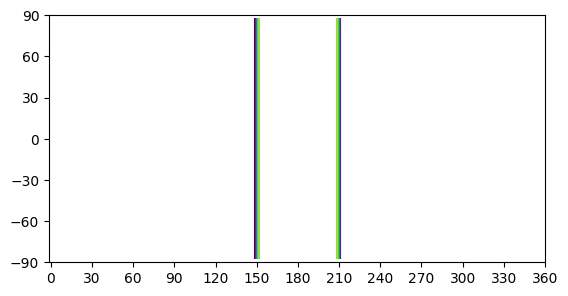

In [3]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get two datasets, `ds_all`, one for ocean and one for land, for a given latitude bin.

In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

In [5]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
# season = 'summer'
season = 'all'

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65

ds_all = {'land':[], 'ocean': []}
ds_summer = []
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
with tqdm(total=n_exp*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for surf in ['land', 'ocean']:
            ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
            ds_use = ds_use.sel(lon=np.unique(lon[surf]), method='nearest')
            ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
            if season == 'summer':
                # Only consider summer as has expected circulation
                ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
                ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
                # Combine hemispheres and average over longitude, time and latitude.
                # Note that April, May, June, October, November and December will not be included in this dataset
                ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
            ds_all[surf] += [ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))]
            ds_all[surf][i].load()
            if season == 'summer':
                # Get rid of nan values corresponding to the winter hemisphere - half the values are nan
                ds_all[surf][i] = ds_all[surf][i].sel(lon_lat_time =
                                                      ds_all[surf][i].lon_lat_time[np.invert(np.isnan(ds_all[surf][i].temp[0]))].to_numpy())
            # if surf == 'ocean':
            #     ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
            #     ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
            #     # Combine hemispheres and average over longitude, time and latitude.
            #     ds_use = xr.concat([ds_nh_summer, ds_sh_summer], dim='lat')
            #     ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
            #     ds_summer += [ds_use]
            #     ds_summer[i].load()
            pbar.update(1)

100%|██████████| 4/4 [00:36<00:00,  9.04s/it]


## MSE Percentile vs Temperature Percentile
Recreating Extended Data Figure 1 of Byrne 2021.

This shows the moist static energy percentiles (y-axis) corresponding to the average moist static energy of days exceeding the given temperature percentile.

The ocean plot shows good agreement with Byrne 2021, and this also shows that for land, in the warmer simulation, there is a decrease in $p_x$ as seen in Byrne 2021.

However, here we see an increase in $p_x$ for large $x$ over land, but in byrne 2021, we see a decrease.

In [6]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
def get_quant_ind(dataset, percentile):
    # Function to find indices in dataset corresponding to surface temperature above a given quantile
    quantile_thresh = dataset.temp[-1].quantile(percentile/100, dim='lon_lat_time', keep_attrs=True)
    quant_ind = np.where(dataset.temp[-1] > quantile_thresh)[0]
    return quant_ind

surfaces = ['ocean', 'land']
n_surf = len(surfaces)
quant_plot = np.arange(100)     # first value must be 0 so temp_quant[0] is the mean value
n_quant = len(quant_plot)

# surface values corresponding to the average obove a given percentile in temperature
temp_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
sphum_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
z_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
mse_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}


with tqdm(total=n_exp*n_quant*n_surf, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j, quant in enumerate(quant_plot):
            for surf in surfaces:
                use_ind = get_quant_ind(ds_all[surf][i], quant)
                temp_quant[surf][i, j] = np.mean(ds_all[surf][i].temp[-1][use_ind])
                sphum_quant[surf][i, j] = np.mean(ds_all[surf][i].sphum[-1][use_ind])
                z_quant[surf][i, j] = np.mean(ds_all[surf][i].height[-1][use_ind])
                mse_quant[surf][i, j] = np.mean(moist_static_energy(ds_all[surf][i].temp[-1][use_ind],
                                                                    ds_all[surf][i].sphum[-1][use_ind],
                                                                    ds_all[surf][i].height[-1][use_ind]))
                pbar.update(1)

# temp_mean = {surf: np.asarray([temp_quant[surf][i][0] for i in range(n_exp)]) for surf in surfaces}

100%|██████████| 400/400 [00:31<00:00, 12.83it/s]


In [7]:
# Get MSE percentile, p_x, corresponding to MSE averaged over all days exceeding x percentile in temperature
mse_quant_px = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
with tqdm(total=n_exp*n_quant*n_surf, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for surf in surfaces:
            mse_all = moist_static_energy(ds_all[surf][i].temp[-1], ds_all[surf][i].sphum[-1], ds_all[surf][i].height[-1])
            for j, quant in enumerate(quant_plot):
                mse_quant_px[surf][i, j] = percentileofscore(mse_all, mse_quant[surf][i, j])
                pbar.update(1)

100%|██████████| 400/400 [00:00<00:00, 521.79it/s]


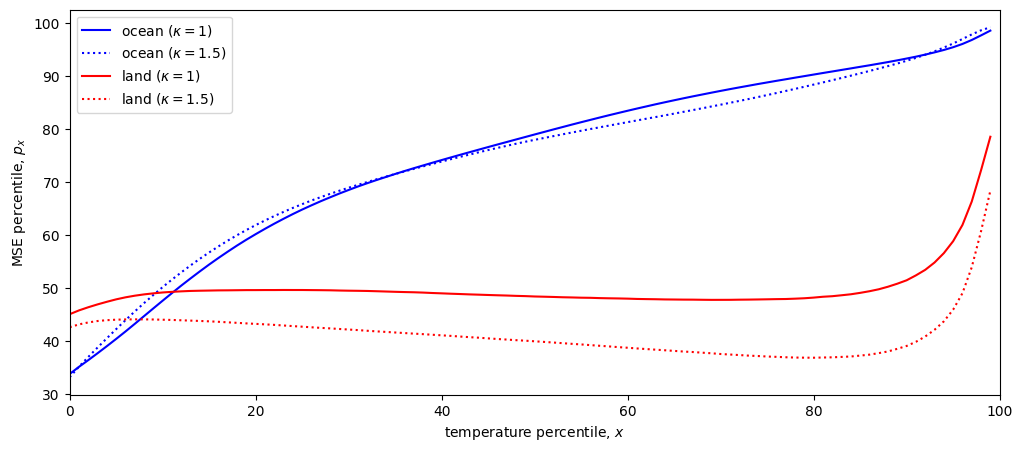

In [8]:
plt_color = {'land': 'red', 'ocean': 'blue'}
linestyles = ['-', ':']     # different for each kappa
fig, ax = plt.subplots(1,1, figsize=(12, 5), sharex=True)
for surf in surfaces:
    for i in range(n_exp):
        ax.plot(quant_plot, mse_quant_px[surf][i], color=plt_color[surf], linestyle=linestyles[i],
                label=f'{surf} ($\kappa={tau_lw[i]}$)')
ax.legend()
ax.set_xlabel('temperature percentile, $x$')
ax.set_ylabel('MSE percentile, $p_x$')
ax.set_xlim(0,100);

## Land to Ocean changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3.

It seems pretty close to the results shown in the paper, implying that the assumption of equal change in MSE percentiles over land and ocean: $\delta h_L(p) = \delta h_O(p)$ may also be valid.

However, the scaling $\lambda(p) = \frac{\delta h_L(p)}{\delta h_O(p)}$, is clearly more than 1 for percentiles greater than 1, and the difference to 1 is more significant than in the paper.

The vertical black lines indicate the range of $p^x$ that corresponds to the complete range of $x$ from 0 to 100.

In [9]:
# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
# mse as function of mse quantile not temp quantile
mse_quant2 = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}

for i in range(n_exp):
        for k, ds_use in enumerate([ds_all['ocean'], ds_all['land']]):
            temp_quant2[surfaces[k]][i] = ds_use[i].temp[-1].quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
            sphum_quant2[surfaces[k]][i] = ds_use[i].sphum[-1].quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
            mse = moist_static_energy(ds_use[i].temp[-1], ds_use[i].sphum[-1], ds_use[i].height[-1])
            mse_quant2[surfaces[k]][i] = mse.quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)

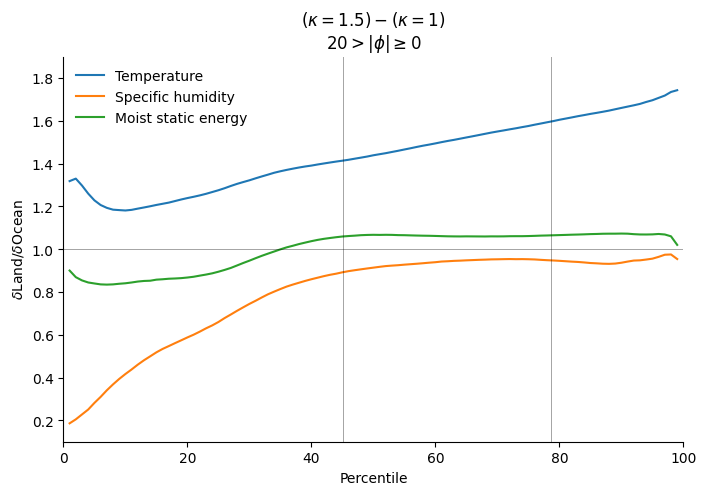

In [10]:
save_lambda_fig = False
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
labels = ['Temperature', 'Specific humidity', 'Moist static energy']
# don't plot the p=0 percentile as doesn't really make any sense
for i, var in enumerate([temp_quant2, sphum_quant2, mse_quant2]):
    ax.plot(quant_plot[np.where(quant_plot>0)], ((var['land'][1]-var['land'][0])/(var['ocean'][1]-var['ocean'][0])
                                                 )[np.where(quant_plot>0)], label=labels[i])
ax.hlines(1,0,100, color='k', linewidth=0.5, alpha=0.5)
ax.legend(loc='upper left', frameon=False)
ax.set_xlabel('Percentile')
ax.set_ylabel('$\delta$Land/$\delta$Ocean')
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
ax.vlines([mse_quant_px['land'][0].min(), mse_quant_px['land'][0].max()], 0, 2, color='k', linewidth=0.5, alpha=0.5)
ax.set_ylim(0.1,1.9)
ax.set_xlim(0, 100);
if save_fig or save_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_{region.lower()}_{season}",dpi=high_dpi if publish_fig else low_dpi)

## Theory for $\delta T_L^x$
Below, I try to replicate Figure 2 from the paper. This uses equation 5 in the paper which is based on the assumption of equal change in MSE percentiles over land and ocean: $\delta h_L(p) = \delta h_O(p)$ i.e. $\lambda(p) = 1$.

The theory does pretty well at low percentiles, but seems to get worse as $x$ increases, with the wrong trend being seen for the largest $x$.

In [18]:
p_surface = float(ds_all['land'][0].pfull[-1]) * 100  # pressure where surface temperature is computed - same for all ds

def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def clausius_clapeyron_factor(temp):
    # Alpha in byrne 2021
    return L_v / (R_v * temp**2)

# Land constants required - all averaged over the x percentile temperature day
# i.e. there are 100 values for each of these constants
alpha_l = clausius_clapeyron_factor(temp_quant['land'][0])
q_l_x_sat = sphum_sat(temp_quant['land'][0], p_surface)
q_l_mean_sat = q_l_x_sat[0]
q_l_x = sphum_quant['land'][0]
r_l_x = q_l_x / q_l_x_sat
delta_r_l_x = sphum_quant['land'][1]/sphum_sat(temp_quant['land'][1], p_surface) - r_l_x
r_l_mean = r_l_x[0]
delta_r_l_mean = delta_r_l_x[0]

# Ocean constants required - these are for the percentile px which corresponds to the average above the x percentile in temperature
# We assume the change in the p xth percentile of ocean moist static energy can be written to good approximation as
# a function of the individual changes in the pxth percentiles of temperature and specific humidity - from Methods page of paper
p_x = np.round(mse_quant_px['land'][0]).astype(int)        # p_x[i] is the percentile of MSE corresponding to average above the
                                                            # percentile quant_all[i] of temperature in reference climate.
temp_o = temp_quant2['ocean'][0][p_x]
delta_temp_o = temp_quant2['ocean'][1][p_x] - temp_o
q_o = sphum_quant2['ocean'][0][p_x]
q_o_sat = sphum_sat(temp_o, p_surface)
r_o = q_o / q_o_sat
delta_r_o = sphum_quant2['ocean'][1][p_x]/sphum_sat(temp_quant2['ocean'][1][p_x], p_surface) - r_o
alpha_o = clausius_clapeyron_factor(temp_o)

e_const = L_v * alpha_l * q_l_x_sat / (c_p + L_v * alpha_l * q_l_x)
nabla = q_l_mean_sat / q_l_x_sat * e_const / alpha_l
gamma_t = (c_p + L_v * alpha_o * q_o) / (c_p + L_v * alpha_l * q_l_x)
gamma_r_o = L_v * q_o_sat / (c_p + L_v * alpha_l * q_l_x)

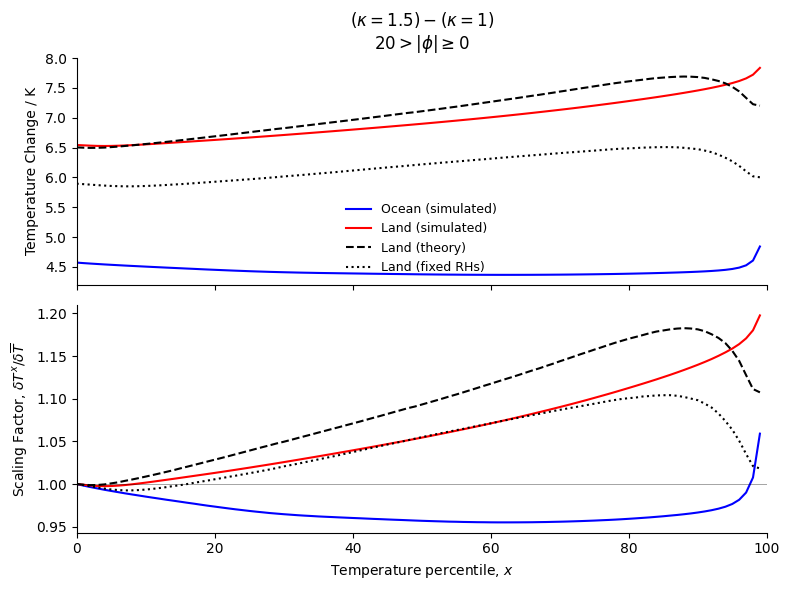

In [21]:
# Plot temperature change vs percentile
save_theory_fig = False
temp_diff_land_theory = (gamma_t * delta_temp_o + gamma_r_o * delta_r_o - nabla * delta_r_l_mean) / (1 + e_const * delta_r_l_x)
temp_diff_land_theory_fix_rh = gamma_t * delta_temp_o
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
temp_diff_quant = {'ocean': [], 'land': []}
for surf in ['ocean', 'land']:
    temp_diff_quant[surf] = temp_quant[surf][1]-temp_quant[surf][0]
    ax[0].plot(quant_plot, temp_diff_quant[surf], label=f'{surf.capitalize()} (simulated)', color=plt_color[surf])
    ax[1].plot(quant_plot, temp_diff_quant[surf]/temp_diff_quant[surf][0], color=plt_color[surf])
ax[0].plot(quant_plot, temp_diff_land_theory, label=f'Land (theory)', linestyle='--', color='k')
ax[0].plot(quant_plot, temp_diff_land_theory_fix_rh, label=f'Land (fixed RHs)', linestyle=':', color='k')
ax[1].plot(quant_plot, temp_diff_land_theory/temp_diff_land_theory[0], label=f'Land (theory)', linestyle='--', color='k')
ax[1].plot(quant_plot, temp_diff_land_theory_fix_rh/temp_diff_land_theory_fix_rh[0],
           label=f'Land (fixed RHs)', linestyle=':', color='k')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature percentile, $x$')
ax[0].legend(fontsize=9, frameon=False)
ax[0].set_xlim(0,100)
# ax[0].set_ylim(4, 8.5)
# ax[1].set_ylim(0.8, 1.5)
ax[1].hlines(1,0,100, color='k', linewidth=0.5, alpha=0.5)
# ax[0].set_ylim(4, 8.5)
# ax[1].set_ylim(0.9, 1.25)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()

if save_fig or save_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

In [39]:
# sanity check that theory in isca_tools works
# The only difference here is due to the version of clausius clapeyron used
for i, const_rh in enumerate([False, True]):
    temp_diff_land_theory2 = get_delta_temp_quant_theory(temp_quant['land'][:, 0], sphum_quant['land'][:, 0], temp_quant['land'],
                                                         temp_quant2['ocean'], sphum_quant['land'], sphum_quant2['ocean'], quant_plot,
                                                         get_px(ds_all['land'], mse_quant['land'], quant_plot, True), p_surface, const_rh)
    if i ==0:
        print(np.abs(temp_diff_land_theory2[0] - temp_diff_land_theory).max())
    else:
        print(np.abs(temp_diff_land_theory2[0] - temp_diff_land_theory_fix_rh).max())

0.02239023321210798
0.020725958174190318


## Components of land temperature response
This is to replicate Figure 4 in Byrne 2021.

In [ ]:
temp_theory_terms = [gamma_t * delta_temp_o,
                     gamma_r_o * delta_r_o,
                     -(e_const/alpha_l)*delta_r_l_x/(1+e_const * delta_r_l_x),
                     e_const/alpha_l*(delta_r_l_x - delta_r_l_mean * q_l_mean_sat/q_l_x_sat)]
temp_theory_terms = np.asarray(temp_theory_terms)
labels = ['$\delta T_O$ comp.', '$\delta r_O$ comp.', '$\delta r_L$ comp.', '$\Delta h$ comp.']
colors = ['cyan', 'blue', 'red', 'purple']
fig, ax = plt.subplots(1,1, figsize=(14, 5), sharex=True)
ax.plot(quant_plot, temp_diff_land_theory, label=f'Theory', color='k')
for i, var in enumerate(temp_theory_terms):
    ax.plot(quant_plot, var, label=labels[i], color=colors[i])
ax.plot(quant_plot, np.sum(temp_theory_terms[-2:], axis=0), color='red', linestyle='--', label='$\delta r_L^{total}$ comp.')
ax.plot(quant_plot, np.sum(temp_theory_terms, axis=0), color='k', linestyle='--', label='Sum')
ax.legend()
ax.hlines([0],0,100, color='grey', lw=0.5)
ax.set_xlabel('temperature Percentile, $x$')
ax.set_ylabel('Temperature change / $K$')
ax.set_xlim(0,100);

The below plot shows the $\gamma$ scaling parameters, as in Extended Figure 4.

In [ ]:
gamma_r_l = -nabla/(100+e_const)
save_gamma_fig = False
fig, ax = plt.subplots(2,1, figsize=(14, 7), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].plot(quant_plot, gamma_t, color='k', label='$\gamma^{T_O}$')
ax[1].plot(quant_plot, gamma_r_o/100, color='b', label='ocean $\gamma^{r_O}$')
ax[1].plot(quant_plot, gamma_r_l, color='r', label='land $\gamma^{r_L}$')
ax[1].hlines([0],0,100, color='k', lw=0.5, alpha=0.5)
ax[0].legend(frameon=False)
ax[0].set_ylabel('sensitivity to $\delta T_O$ [$K/K$]')
ax[1].legend(frameon=False)
ax[1].set_ylabel('sensitivity to $\delta r$ [$K/$%]')
ax[0].set_xlim(0,100)
ax[1].set_ylim(-np.max([gamma_r_o.max()/100, np.abs(gamma_r_l).max()])-0.04,
               np.max([gamma_r_o.max()/100, np.abs(gamma_r_l).max()])+0.04)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()
if save_fig or save_gamma_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/gamma_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

## Why does the theory not work?
From the above plots, it is clear that the theory given by equation 5 in the paper does not do particularly well in predicting the temperature response at large $x$. The rest of this notebook is looking into why this is the case.


### Supplementary Figure 7 - calculation of $\delta h_O(p_x)$
The first assumption we check, is that of equation 10 which assumes that the change in the $p^x$th percentile of ocean moist static energy can be written to good approximation as a function of the individual changes in the $p^x$th percentiles of temperature and specific humidity i.e. we want to check if the assumption that $\delta h_O(p_x) \approx c_p \delta T_O(p_x) + L_v \delta q_O(p_x)$ holds.

If this assumption were to hold, then both the black lines in the plot below would overlap. We see that it holds to within 3% for all percentiles, which while more than the 0.5% in Byrne 2021, is still pretty good.

However, the taylor expansion of $\delta h_O(p_x)$ used in the $\delta T_L^x$ equation is shown as a solid red line. This clearly differs greatly from either of the black lines, implying it may be appropriate to use further terms in the taylor expansion.

The red dotted line includes both the non-linear $\delta T_O \delta r_O$ term and the squared $\delta T_O^2$ term and matches the black lines much better.

If I then further work backwards from my definition of saturation vapour pressure to get a more accurate $\alpha$, it gives the red dotted and dashed line. This almost exactly matches the black dashed line, which is what we would expect a perfect taylor series to do, so we don't need any more terms.

In [15]:
def clausius_clapeyron_factor2(temp):
    # Rather than saying d_sphum_sat_d_temp = alpha \times sphum_sat,
    # here I explicitly compute alpha from the formula for saturation_vapor_pressure using in isca_tools
    lambda_const = 4302.645 / (temp - 29.65)**2
    return lambda_const * p_surface / epsilon * sphum_sat(temp, p_surface) / saturation_vapor_pressure(temp)

alpha_o_2 = clausius_clapeyron_factor2(temp_o)
alpha_l_2 = clausius_clapeyron_factor2(temp_quant['land'][0])

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(quant_plot, mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x], color='k', label='$\delta h_O(p_x)$')
ax.plot(quant_plot, (c_p * delta_temp_o +
         L_v * (sphum_quant2['ocean'][1][p_x]-sphum_quant2['ocean'][0][p_x]))/1000, color='k',
        label='$c_p \delta T_O(p_x) + L_v \delta q_O(p_x)$', linestyle='--')

term0 = c_p * delta_temp_o
term1 = L_v * alpha_o * q_o * delta_temp_o
term2 = L_v * q_o_sat * delta_r_o
term3 = L_v * q_o_sat * alpha_o * delta_r_o * delta_temp_o
term4 = 0.5 * L_v * q_o * alpha_o * (alpha_o - 2/temp_o)*delta_temp_o**2
mse_taylor_terms = {'ocean': {'alpha1': np.asarray([term0, term1, term2, term3, term4])} , 'land': {}}
ax.plot(quant_plot, np.sum(mse_taylor_terms['ocean']['alpha1'][:3], axis=0)/1000, color='r', linestyle='-',
        label='$(c_p+L_v\\alpha_O q_O) \delta T_O(p_x) + L_v q_{O,sat} \delta r_O(p_x)$')
ax.plot(quant_plot, np.sum(mse_taylor_terms['ocean']['alpha1'][:4], axis=0)/1000, color='r', linestyle='--',
        label='With non-linear $\delta T_O \delta r_O$ term')
ax.plot(quant_plot, np.sum(mse_taylor_terms['ocean']['alpha1'], axis=0)/1000, color='r', linestyle=':',
        label='With non-linear and $\delta T_O^2$ terms')

term1 = L_v * alpha_o_2 * q_o * delta_temp_o
term2 = L_v * q_o_sat * delta_r_o
term3 = L_v * q_o_sat * alpha_o_2 * delta_r_o * delta_temp_o
term4 = 0.5 * L_v * q_o * alpha_o_2 * (alpha_o_2 - 2/temp_o)*delta_temp_o**2
mse_taylor_terms['ocean']['alpha2'] = np.asarray([term0, term1, term2, term3, term4])

ax.plot(quant_plot, np.sum(mse_taylor_terms['ocean']['alpha2'], axis=0)/1000, color='r', linestyle='-.',
        label='With all terms and $\\alpha$ from Bolton')

ax.set_xlabel('temperature percentile, $x$')
ax.set_ylabel('MSE change / $kJ/kg$')
ax.legend()
ax.set_xlim(0,100);

### Calculation of $\delta h_L^x$
As with the taylor expansion for ocean MSE change above, the land MSE change taylor expansion also needs additional terms.

The approximation used in equation 5 of the paper is showed by the red dashed line (including the non-linear $\delta T^x_L \delta r^x_L$ term). But we see that including the squared term, $(\delta T^x_L)^2$, and changing the definition of $\alpha$ helps match it to the simulated value.

In [ ]:
term0 = c_p * temp_diff_quant['land']
term1 = L_v * alpha_l * q_l_x * temp_diff_quant['land']
term2 = L_v * q_l_x_sat * delta_r_l_x
term3 = L_v * q_l_x_sat * alpha_l * delta_r_l_x * (temp_quant['land'][1]-temp_quant['land'][0])
term4 = 0.5 * L_v * q_l_x * alpha_l * (alpha_l - 2/temp_quant['land'][0])*(temp_quant['land'][1]-temp_quant['land'][0])**2
mse_taylor_terms['land']['alpha1'] = np.asarray([term0, term1, term2, term3, term4])

fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(quant_plot, mse_quant['land'][1]-mse_quant['land'][0], color='k', label='$\delta h^x_L$')
ax.plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha1'][:3], axis=0)/1000, color='r',
        label='$(c_p+L_v\\alpha_L q_L) \delta T^x_L + L_v q_{L,sat} \delta r^x_L$')
ax.plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha1'][:4], axis=0)/1000, color='r', linestyle='--',
        label='With non-linear $\delta T^x_L \delta r^x_L$ term')
ax.plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha1'], axis=0)/1000, color='r', linestyle=':',
        label='With non-linear and $(\delta T^x_L)^2$ terms')

term1 = L_v * alpha_l_2 * q_l_x * temp_diff_quant['land']
term2 = L_v * q_l_x_sat * delta_r_l_x
term3 = L_v * q_l_x_sat * alpha_l_2 * delta_r_l_x * temp_diff_quant['land']
term4 = 0.5 * L_v * q_l_x * alpha_l_2 * (alpha_l_2 - 2/temp_quant['land'][0])*temp_diff_quant['land']**2
mse_taylor_terms['land']['alpha2'] = np.asarray([term0, term1, term2, term3, term4])

ax.plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha2'], axis=0)/1000, color='r', linestyle='-.',
        label='With all terms and $\\alpha$ from Bolton')

ax.legend()
ax.set_xlabel('temperature percentile, $x$')
ax.set_ylabel('MSE change / $kJ/kg$')
ax.set_xlim(0,100);

### Calculation of $\delta q_O(p_x)$ and $\delta q_L^x$
The problem above only arises from the taylor expansion of the change in specific humidity, $\delta q$, terms. So here we do the same analysis but just for this.

It gives the same conclusions regarding the additional terms required in the taylor expansion.

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(14, 8), sharex=True)
ax[0].plot(quant_plot, sphum_quant2['ocean'][1][p_x]-sphum_quant2['ocean'][0][p_x], color='k', label='$\delta q_O(p_x)$')
ax[0].plot(quant_plot, np.sum(mse_taylor_terms['ocean']['alpha1'][1:3], axis=0)/L_v, color='r', linestyle='-',
        label='$\\alpha_O q_O \delta T_O(p_x) + q_{O,sat} \delta r_O(p_x)$')
ax[0].plot(quant_plot, np.sum(mse_taylor_terms['ocean']['alpha1'][1:4], axis=0)/L_v, color='r', linestyle='--',
        label='With non-linear $\delta T_O \delta r_O$ term')
ax[0].plot(quant_plot, np.sum(mse_taylor_terms['ocean']['alpha1'][1:], axis=0)/L_v, color='r', linestyle=':',
        label='With non-linear and $\delta T_O^2$ terms')
ax[0].plot(quant_plot, np.sum(mse_taylor_terms['ocean']['alpha2'][1:], axis=0)/L_v, color='r', linestyle='-.',
        label='With all terms and $\\alpha$ from Bolton')
fig.supylabel('Specific humidity change / $kg/kg$')
ax[0].legend()

ax[1].plot(quant_plot, sphum_quant['land'][1]-sphum_quant['land'][0], color='k', label='$\delta q^x_L$')
ax[1].plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha1'][1:3], axis=0)/L_v, color='r',
        label='$\\alpha_L q_L \delta T^x_L + L_v q_{L,sat} \delta r^x_L$')
ax[1].plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha1'][1:4], axis=0)/L_v, color='r', linestyle='--',
        label='With non-linear $\delta T^x_L \delta r^x_L$ term')
ax[1].plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha1'][1:], axis=0)/L_v, color='r', linestyle=':',
        label='With non-linear and $(\delta T^x_L)^2$ terms')
ax[1].plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha2'][1:], axis=0)/L_v, color='r', linestyle='-.',
        label='With all terms and $\\alpha$ from Bolton')
ax[1].legend()
ax[1].set_xlabel('temperature percentile, $x$')
ax[0].set_xlim(0,100)
plt.tight_layout();

The difference between the red dotted and red dashed-dotted line is due to using an inappropriate $\alpha$ value. If I compute $\alpha$ explicitly from the [equation for saturation vapour pressure](http://127.0.0.1:8000/code/utils/moist_physics/#isca_tools.utils.moist_physics.saturation_vapor_pressure) used in the Byrne 2021 paper, I get a lower value of $\alpha$ (as shown below) which results in a better fit above.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(temp_o, alpha_o, label='$\\alpha = \\frac{L_v}{R_v T^2}$')
ax.plot(temp_o, alpha_o_2, label='$\\alpha$ from Bolton 1980 Equation 10')
ax.set_xlabel('temperature [$K$]')
ax.legend();

### Checking Equation 24, $\Delta h = L_v(\delta r_L^x q^x_{L,sat} - \delta \bar{r_L}  \overline{q_{L,sat}})$

If we assume that $\delta h_L(p) = \delta h_O(p)$, then we get equation 9: $\delta h_L^x = \delta h_O(p^x) + \Delta h$ where:
$$\Delta h = h_L^{\kappa_{warm}}(p^x + \delta p^x) - h_L^{\kappa_{warm}}(p^x)$$

It the paper, it then derives a theory for $\Delta h$ given by equation 24: $\Delta h = L_v(\delta r_L^x q^x_{L,sat} - \delta \bar{r_L}  \overline{q_{L,sat}})$.

In the top plot below, we see that there is a significant difference between the simulated value (blue dotted line) and that predicted by this theory (red), implying the theory may need evaluating.

In the top plot, we also see that there is a bug difference between the simulated value of $\delta h^x_L - \delta h_O(p_x)$ (solid blue line) and the simulated value of $\Delta h = h_L^{\kappa_{warm}}(p^x + \delta p^x) - h_L^{\kappa_{warm}}(p^x)$. This implies the assumption that $\lambda(p) = \frac{\delta h_L(p)}{\delta h_O(p)} = 1$ is incorrect.

If we instead use the exact value of $\lambda(p)$, we get $\Delta h = \delta h_L^x - \lambda(p^x) \delta h_O(p^x)$. We show this as the blue solid line in the second plot, and see that it almost exactly matches the blue dotted line.

In black, we also include various taylor expansion simplifications for $\delta h_L^x$ and $\delta h_O(p^x)$. We see that the simplest expansion that matches the blue lines well is going up to the non-linear $\delta T_L^x\delta r_L^x$ term for land and just including the two linear terms for ocean. This is promising, as this is what was used in the paper.

In [ ]:
# Get actual delta_h from change in quantile formula
mse_all = moist_static_energy(ds_all[surf][1].temp[-1], ds_all[surf][1].sphum[-1], ds_all[surf][1].height[-1])
delta_h = np.quantile(mse_all, mse_quant_px['land'][1]/100) - np.quantile(mse_all, mse_quant_px['land'][0]/100)

# theory for delta_h using equation 24 in the paper
delta_h_theory = L_v * (delta_r_l_x * q_l_x_sat - delta_r_l_mean * q_l_mean_sat)

# Actual ratio between MSE changes on land vs ocean for percentile p_x - assume this to be 1 in paper
lambda_px = (mse_quant2['land'][1][p_x]-mse_quant2['land'][0][p_x])/(mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x])

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(14, 10), sharex=True, sharey=True)
# ax.plot(quant_plot, term_sum - (term1+term2)/1000)
ax[0].plot(quant_plot, mse_quant['land'][1]-mse_quant['land'][0] - (mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x]),
        label='Simulated, $\delta h_L^x - \delta h_O(p^x)$', color='b')
ax[0].plot(quant_plot, delta_h, color='b', linestyle=':',
        label='Simulated, $\delta h^{\kappa_{warm}}_L(p^x+\delta p^x) - \delta h^{\kappa_{warm}}_L(p^x)$')
ax[0].plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha2'][:3], axis=0)/1000 -
        np.sum(mse_taylor_terms['ocean']['alpha2'][:3], axis=0)/1000,
        label='$\delta h_L^x(\delta T_L^x, \delta r_L^x) - \delta h_O^x(\delta T_O, \delta r_O^x)$', color='k', linestyle=':')
ax[0].plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha2'][:4], axis=0)/1000 -
        np.sum(mse_taylor_terms['ocean']['alpha2'][:3], axis=0)/1000, linestyle='--', color='k',
        label='$\delta h_L^x(\delta T_L^x, \delta r_L^x, \delta T_L^x\delta r_L^x) - \delta h_O^x(\delta T_O, \delta r_O^x)$')
ax[0].plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha2'], axis=0)/1000 -
        np.sum(mse_taylor_terms['ocean']['alpha2'], axis=0)/1000,
        label='Includes Non-linear and Squared Terms', linestyle='--', color='grey')
ax[0].plot(quant_plot, delta_h_theory/1000, label='Theory', color='r')
ax[0].legend()
fig.supylabel('$\Delta h$ [kJ/kg]')
ax[0].set_title('Assumes $\delta h_L(p) = \delta h_O(p)$')

ax[1].plot(quant_plot, (mse_quant['land'][1]-mse_quant['land'][0]) - lambda_px*(mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x]),
        label='Simulated, $\delta h_L^x - \delta h_O(p^x)$', color='b')
ax[1].plot(quant_plot, delta_h, color='b', linestyle=':',
        label='Simulated, $\delta h^{\kappa_{warm}}_L(p^x+\delta p^x) - \delta h^{\kappa_{warm}}_L(p^x)$')
ax[1].plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha2'][:3], axis=0)/1000 -
        lambda_px*np.sum(mse_taylor_terms['ocean']['alpha2'][:3], axis=0)/1000,
        label='$\delta h_L^x(\delta T_L^x, \delta r_L^x) - \delta h_O^x(\delta T_O, \delta r_O^x)$', color='k', linestyle=':')
ax[1].plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha2'][:4], axis=0)/1000 -
        lambda_px*np.sum(mse_taylor_terms['ocean']['alpha2'][:3], axis=0)/1000, linestyle='--', color='k',
        label='$\delta h_L^x(\delta T_L^x, \delta r_L^x, \delta T_L^x\delta r_L^x) - \delta h_O^x(\delta T_O, \delta r_O^x)$')
ax[1].plot(quant_plot, np.sum(mse_taylor_terms['land']['alpha2'], axis=0)/1000 -
        lambda_px*np.sum(mse_taylor_terms['ocean']['alpha2'], axis=0)/1000,
        label='Includes Non-linear and Squared Terms', linestyle='--', color='grey')
ax[1].plot(quant_plot, delta_h_theory/1000, label='Theory', color='r')
ax[1].set_title('Assumes $\delta h_L(p) = \lambda(p) \delta h_O(p)$')
fig.supxlabel('temperature percentile, $x$')
ax[0].set_xlim([0,100]);

### Extended Data Figure 3
The below plot is a recreation of Extended Data Figure 3, emphasizing that the theory for $\Delta h$ does not do well - the $\Delta h$ plot is just a recreation of the red solid line and dotted blue line above.

In the top plot, the $\delta p^x$ theoretical value comes from equation 23 in the paper: $\delta p^x \approx \frac{L_v}{\beta_1}(\delta r_L^x q^x_{L,sat} - \delta \bar{r_L}  \overline{q_{L,sat}})$

In [ ]:
# Test equations 23 and 24
mse_all = moist_static_energy(ds_all['land'][0].temp[-1], ds_all['land'][0].sphum[-1], ds_all['land'][0].height[-1])
p_mean = int(np.round(percentileofscore(mse_all, float(np.mean(mse_all)))))
beta1 = np.gradient(mse_quant2['land'][0], quant_plot)[p_mean] * 1000
beta2 = np.gradient(mse_quant2['land'][0], quant_plot)[p_x] * 1000

fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
# plt.plot(quant_plot, beta1 * (p_x - p_mean) + float(np.mean(mse_all)))
# plt.plot(quant_plot, mse_quant2['land'][0][p_x])
ax[0].plot(quant_plot, mse_quant_px['land'][1] - mse_quant_px['land'][0], color='k', label='simulated')
ax[0].plot(quant_plot, L_v / beta1 * (delta_r_l_x * q_l_x_sat - delta_r_l_mean * q_l_mean_sat), color='k', linestyle='--',
           label='theory ($\\beta_1$)')
ax[0].plot(quant_plot, L_v / beta2 * (delta_r_l_x * q_l_x_sat - delta_r_l_mean * q_l_mean_sat), color='k', linestyle=':',
           label='theory ($\\beta_2$)')
ax[1].plot(quant_plot, delta_h, color='k', label='simulated')
ax[1].plot(quant_plot, L_v/1000 * (delta_r_l_x * q_l_x_sat - delta_r_l_mean * q_l_mean_sat), color='k', linestyle='--', label='theory')
ax[0].legend()
ax[0].set_ylabel('$\delta p_x$')
ax[1].set_ylabel('$\Delta h$ [kJ/kg]')
ax[1].set_xlabel('temperature percentile, $x$')
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
ax[0].set_xlim([0,100]);

### Form of MSE equation to start theory
The starting equation used in the paper is equation 9, $\delta h_L^x = \delta h_O(p^x) + \Delta h$. The plot below shows that this is not valid for this simulation, and instead we need $\delta h_L^x = \lambda(p^x) \delta h_O(p^x) + \Delta h$.

In this plot, no theories are used for any of the individual terms, they are instead computed directly from the output data of the simulation.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.plot(quant_plot, mse_quant['land'][1]-mse_quant['land'][0], label='$\delta h_L^x$')
ax.plot(quant_plot, mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x], label='$\delta h_O(p^x)$')
ax.plot(quant_plot, mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x] + delta_h, label='$\delta h_O(p^x) + \Delta h$')
ax.plot(quant_plot, lambda_px * (mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x]) + delta_h,
        label = '$\lambda(p^x) \delta h_O(p^x) + \Delta h$')
ax.set_ylabel('MSE Change [$kJ/kg$]')
ax.set_xlabel('temperature percentile, $x$')
ax.legend()
ax.set_xlim(0,100);

## Hierarchy of Theories for $\delta T_L^x$

The theory for $\delta T_L^x$ is based on considering the change in MSE of days exceeding the $x$th percentile in temperature, $\delta h_L^x = h_L^{\kappa_{warm}}(p^x_{\kappa_{warm}}) - h_L^{\kappa_{ref}}(p^x_{\kappa_{ref}})$ where $p^x = p^x_{ref}$ is the percentile of MSE corresponding to the MSE averaged over all days exceeding percentile $x$ in temperature in the reference simulation. Equally, $p^x +\delta p^x = p^x_{\kappa_{warm}}$ is the percentile of MSE corresponding to the MSE averaged over all days exceeding percentile $x$ in temperature in the warmer simulation (the MSE distribution changes with warming so the percentile of MSE corresponding to a given temperature percentile will also change).

So we have $\delta h_L^x = h_L^{\kappa_{warm}}(p^x + \delta p^x) - h_L^{\kappa_{ref}}(p^x)$.
Then subbing in for $\delta h_L(p^x) = \lambda(p^x) \delta h_O(p^x) =  h_L^{\kappa_{warm}}(p^x) - h_L^{\kappa_{ref}}(p^x)$, we get:
$\delta h_L^x = h_L^{\kappa_{warm}}(p^x + \delta p^x) - h_L^{\kappa_{warm}}(p^x) + \lambda(p^x) \delta h_O(p^x)$
Then we can use the definition of $\Delta h = h_L^{\kappa_{warm}}(p^x + \delta p^x) - h_L^{\kappa_{warm}}(p^x)$ to give:
$\delta h_L^x = \lambda(p^x) \delta h_O(p^x) + \Delta h$

To turn this into a theory for $\delta T_L^x$ we need to expand $\delta h_L^x$ in a taylor series of $\delta T_L^x$ and $\delta r_L^x$. From the MSE change plot for land, we see that we need to go up to the $(\delta T_L^x)^2$ term in the taylor series and use the correct form of $\alpha$ to best match the actual MSE change (red dot/dashed line matches black line). Doing this taylor expansion, we get the equation:

$$\frac{L_v}{2\Gamma}\alpha_L q_L^x (\alpha_L - \frac{2}{T_L^x})(\delta T_L^x)^2 + (1 + \epsilon \delta r_L^x)\delta T_L^x = - \frac{\epsilon}{\alpha_L}\delta r_L^x + \frac{1}{\Gamma}(\lambda(p^x) \delta h_O(p^x) + \Delta h)$$

Where, $\Gamma = c_p + L_v \alpha_L q_L^x$ and $\epsilon = \frac{L_v \alpha_L q^x_{L,sat}}{\Gamma}$ ($\epsilon$ is used in the paper).

Theory 1 in the plot below shows the solution to this equation (using $\lambda(p^x)$, $\delta h_O(p^x)$ and $\Delta h$ computed directly from the output of the simulation), and it is clear that it matches the simulated value almost exactly.

The other theories in the left plot offer various simplifications to this:
* Theory 2 - Assumes $\lambda(p^x)=1$
* Theory 3 - Uses incorrect $\alpha = \frac{L_v}{R_v T^2}$, instead of that from Bolton 1980 definition of sturation vapour pressure.
* Theory 4 - Uses theory of $\Delta h$ given by equation 24 in the paper.

The theories on the right plot make no assumptions about $\lambda(p^x)$ or $\Delta h$ but use different number of terms in the taylor expansion of $\delta h_L^x$ and $\delta h_O(p^x)$:
* Theory 5 - $\delta h^x_L$ taylor expansion includes non-linear $\delta T^x_L \delta r^x_L$ and squared $(\delta T^x_L)^2$ terms.
$\delta h_O(p^x)$ taylor expansion includes non-linear $\delta T_O \delta r_O$ and squared $\delta T_O^2$ terms.
* Theory 6 - $\delta h^x_L$ taylor expansion includes non-linear $\delta T^x_L \delta r^x_L$ term.
$\delta h_O(p^x)$ taylor expansion includes non-linear $\delta T_O \delta r_O$ term.
* Theory 7 - $\delta h^x_L$ taylor expansion includes non-linear $\delta T^x_L \delta r^x_L$ term.
$\delta h_O(p^x)$ taylor expansion includes just linear terms.
* Theory 8 - $\delta h^x_L$ taylor expansion includes just linear terms.
$\delta h_O(p^x)$ taylor expansion includes just linear terms.

Note that Theory 1 and Theory 5 differ below, only because the assumption that $\delta h_O(p_x) = c_p \delta T_O(p_x) + L_v \delta q_O(p_x)$ is not exactly satisfied, as is shown by the difference between the black solid and black dotted linein the ocean MSE change plot.

From this, we see that Theory 7 is probably the simplest theory that can predict $\delta T_L^x$ well. But we need some sort of theory for $\lambda(p^x)$ and $\Delta h$ to make this a complete theory.

In [ ]:
e_const_2 = L_v * alpha_l_2 * q_l_x_sat / (c_p + L_v * alpha_l_2 * q_l_x)
# Theory 1 - No assumptions
denom = c_p + L_v * alpha_l_2 * q_l_x
coef_a = 0.5 * L_v * alpha_l_2 * q_l_x * (alpha_l_2 - 2/temp_quant['land'][0]) / denom
coef_b = 1 + e_const_2 * delta_r_l_x
coef_c = e_const_2/alpha_l_2 * delta_r_l_x - (
        lambda_px * (mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x])*1000 + 1000*delta_h)/denom
temp_diff_land_theory_1 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

# Theory 2 - Assume equal changes in percentile p of MSE over ocean and land
coef_c = e_const_2/alpha_l_2 * delta_r_l_x - ((mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x])*1000 + 1000*delta_h)/denom
temp_diff_land_theory_2 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

# Theory 4 - With theory in paper for delta_h
coef_c = e_const_2/alpha_l_2 * delta_r_l_x - (
        lambda_px * (mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x])*1000 + delta_h_theory)/denom
temp_diff_land_theory_4 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

# Theory 5 - Taylor expansion including non-linear and squared terms for ocean MSE change
coef_c = e_const_2/alpha_l_2 * delta_r_l_x - (
        lambda_px * np.sum(mse_taylor_terms['ocean']['alpha2'], axis=0) + 1000 * delta_h)/denom
temp_diff_land_theory_5 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

# Theory 6 - Neglect squared term in taylor expansion of land and ocean but keep non linear for both
coef_c = e_const_2/alpha_l_2 * delta_r_l_x - (
        lambda_px * np.sum(mse_taylor_terms['ocean']['alpha2'][:4], axis=0) + 1000*delta_h)/denom
temp_diff_land_theory_6 = -coef_c/coef_b

# Theory 7 - Neglect squared term and non-linear term in ocean, neglect squared term in land.
coef_c = e_const_2/alpha_l_2 * delta_r_l_x - (
        lambda_px * np.sum(mse_taylor_terms['ocean']['alpha2'][:3], axis=0) + 1000*delta_h)/denom
temp_diff_land_theory_7 = -coef_c/coef_b

# Theory 8 - Neglect squared term and non-linear term in ocean and land.
coef_b = 1
temp_diff_land_theory_8 = -coef_c/coef_b

# Theory 3 - Using the wrong version of alpha
denom = c_p + L_v * alpha_l * q_l_x
coef_a = 0.5 * L_v * alpha_l * q_l_x * (alpha_l - 2/temp_quant['land'][0]) / denom
coef_b = 1 + e_const * delta_r_l_x
coef_c = e_const/alpha_l * delta_r_l_x - (
        lambda_px * (mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x])*1000 + 1000*delta_h)/denom
temp_diff_land_theory_3 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

coef_b = 1 + e_const_2 * delta_r_l_x        # change back to correct alpha
denom = c_p + L_v * alpha_l_2 * q_l_x       # change back to correct alpha

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(14, 9), sharex=True, sharey='row')
ax = ax.flatten()
ax[0].plot(quant_plot, temp_diff_quant['land'], label='Simulated')
ax[0].plot(quant_plot, temp_diff_land_theory_1, label='Theory 1')
ax[0].plot(quant_plot, temp_diff_land_theory_2, label='Theory 2')
ax[0].plot(quant_plot, temp_diff_land_theory_3, label='Theory 3')
ax[0].plot(quant_plot, temp_diff_land_theory_4, label='Theory 4')

ax[2].plot(quant_plot, temp_diff_quant['land']/temp_diff_quant['land'][0], label='Simulated')
ax[2].plot(quant_plot, temp_diff_land_theory_1/temp_diff_land_theory_1[0], label='Theory 1')
ax[2].plot(quant_plot, temp_diff_land_theory_2/temp_diff_land_theory_2[0], label='Theory 2')
ax[2].plot(quant_plot, temp_diff_land_theory_3/temp_diff_land_theory_3[0], label='Theory 3')
ax[2].plot(quant_plot, temp_diff_land_theory_4/temp_diff_land_theory_4[0], label='Theory 4')

ax[1].plot(quant_plot, temp_diff_quant['land'], label='Simulated')
ax[1].plot(quant_plot, temp_diff_land_theory_5, label='Theory 5')
ax[1].plot(quant_plot, temp_diff_land_theory_6, label='Theory 6')
ax[1].plot(quant_plot, temp_diff_land_theory_7, label='Theory 7')
ax[1].plot(quant_plot, temp_diff_land_theory_8, label='Theory 8')

ax[3].plot(quant_plot, temp_diff_quant['land']/temp_diff_quant['land'][0], label='Simulated')
ax[3].plot(quant_plot, temp_diff_land_theory_5/temp_diff_land_theory_5[0], label='Theory 5')
ax[3].plot(quant_plot, temp_diff_land_theory_6/temp_diff_land_theory_6[0], label='Theory 6')
ax[3].plot(quant_plot, temp_diff_land_theory_7/temp_diff_land_theory_7[0], label='Theory 7')
ax[3].plot(quant_plot, temp_diff_land_theory_8/temp_diff_land_theory_8[0], label='Theory 8')

ax[0].legend()
ax[1].legend()
ax[0].set_xlim([0,100])
ax[0].set_ylabel('Temperature Change / K')
ax[2].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
fig.supxlabel('Temperature Percentile, $x$')
fig.suptitle(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
plt.tight_layout();

In [ ]:
# Just show each of 3 assumptions independently.
# Theory 2 shows effect of neglecting lambda
# Theory 4 shows effect of using theory for delta h
# Theory 7 shows effect of neglecting squared terms in taylor expansion of h_L and h_O
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(2,1, figsize=(14, 7), sharex=True, sharey='row')
ax[0].plot(quant_plot, temp_diff_quant['land'], label='Simulated')
ax[0].plot(quant_plot, temp_diff_land_theory_2, label='Theory 2', color=default_colors[2])
ax[0].plot(quant_plot, temp_diff_land_theory_4, label='Theory 4', color=default_colors[4])
ax[0].plot(quant_plot, temp_diff_land_theory_7, label='Theory 7', color=default_colors[3])
ax[1].plot(quant_plot, temp_diff_quant['land']/temp_diff_quant['land'][0], label='Simulated')
ax[1].plot(quant_plot, temp_diff_land_theory_2/temp_diff_land_theory_2[0], label='Theory 2', color=default_colors[2])
ax[1].plot(quant_plot, temp_diff_land_theory_4/temp_diff_land_theory_4[0], label='Theory 4', color=default_colors[4])
ax[1].plot(quant_plot, temp_diff_land_theory_7/temp_diff_land_theory_7[0], label='Theory 7', color=default_colors[3])
ax[0].legend()
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
ax[0].set_xlim([0,100])
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
plt.tight_layout();

## Why does $\Delta h$ theory not work?

In [ ]:
# Equation 19 and 22 plot
p_mean = np.zeros(n_exp)
h_l_mean = np.zeros(n_exp)
beta1 = np.zeros(n_exp)
beta2 = np.zeros((n_exp, n_quant))

fig, ax = plt.subplots(2,1, figsize=(10, 7), sharex=True)
for i in range(n_exp):
    mse = moist_static_energy(ds_all['land'][i].temp[-1], ds_all['land'][i].sphum[-1], ds_all['land'][i].height[-1])
    h_l_mean[i] = float(np.mean(mse))
    p_mean[i] = percentileofscore(mse.to_numpy(), h_l_mean[i])
    beta1[i] = np.gradient(mse_quant2['land'][i], quant_plot)[int(np.round(p_mean[i]))]
    beta2[i] = np.gradient(mse_quant2['land'][i], quant_plot)[p_x]
    # Equation 19 plot
    ax[0].plot(quant_plot, mse_quant2['land'][i], color=plt_color[surfaces[i]], label=f'Simulated ($\kappa={tau_lw[i]}$)')
    ax[0].plot(quant_plot, beta1[i]*(quant_plot-p_mean[i])+h_l_mean[i], color=plt_color[surfaces[i]], linestyle='--',
               label=f'Theory ($\kappa={tau_lw[i]}$; $\\beta_1$)')
    ax[0].plot(quant_plot, beta2[i]*(quant_plot-p_mean[i])+h_l_mean[i], color=plt_color[surfaces[i]], linestyle=':',
           label=f'Theory ($\kappa={tau_lw[i]}$; $\\beta_2$)', alpha=0.4)

    ax[1].plot(quant_plot, mse_quant_px['land'][i], color=plt_color[surfaces[i]])
    ax[1].plot(quant_plot, (mse_quant['land'][i] - h_l_mean[i])/beta1[i] + p_mean[i], color=plt_color[surfaces[i]], linestyle='--')
    ax[1].plot(quant_plot, (mse_quant['land'][i] - h_l_mean[i])/beta2[i] + p_mean[i], color=plt_color[surfaces[i]],
               linestyle=':', alpha=0.4)
    p_x_lim = np.min((mse_quant['land'][i] - h_l_mean[i])/beta1[i] + p_mean[i])
    ax[0].scatter(p_x_lim, beta1[i]*(p_x_lim-p_mean[i])+h_l_mean[i], marker='|', s=200, color=plt_color[surfaces[i]], alpha=0.5)
    p_x_lim = np.max((mse_quant['land'][i] - h_l_mean[i])/beta1[i] + p_mean[i])
    ax[0].scatter(p_x_lim, beta1[i]*(p_x_lim-p_mean[i])+h_l_mean[i], marker='|', s=200, color=plt_color[surfaces[i]], alpha=0.5)
    # p_x_max = np.max((mse_quant['land'][i] - h_l_mean[i])/beta1[i] + p_mean[i])


ax[0].set_xlabel('MSE percentile, $p^x$')
ax[0].legend(fontsize=7, loc='upper left')
ax[0].set_ylabel('MSE [$kJ/kg$]')
ax[1].set_ylabel('$p^x$')
ax[1].set_xlabel('temperature percentile, $x$')
ax[0].set_xlim(0,100)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
plt.tight_layout()
print(beta1)
print(p_mean)

The most exact theory for $p^x$ comes from equation 21:

$$p^x = \frac{h_L^x - \overline{h_L}}{\beta_1} + \overline{p}$$

where $\beta_1 = \left.\frac{\partial h_L}{\partial p}\right|_{p=\overline{p}}$.

From the lower plot above, this fails at large $x$. This is because it uses equation 19, $h_L(p^x) \approx \beta_1 (p^x - \overline{p}) + \overline{h_L}$ which is a bad approximation for $p^x$ between about 60 and 90 as shown by the top plot above. This corresponds to $x > 90$.

From this, we can get an equation for $\delta p^x$:

$$\delta p^x = \frac{1}{\beta^{warm}_1}(h_L^{x, warm} - \overline{h_L^{warm}}) -
\frac{1}{\beta^{ref}_1}(h_L^{x, ref} - \overline{h_L^{ref}}) + \delta \overline{p}$$

Using equation 18, we can get an estimate for $\Delta h$ from this:

$$\Delta h = \delta p^x (\beta^{ref}_2 + \delta \beta_2) = \delta p^x \beta^{warm}_2$$

where $\beta_2 = \left.\frac{\partial h_L}{\partial p}\right|_{p=p^x}$

Plots of $\delta p^x$ and $\Delta h$ are shown below.

In [ ]:
# Equation 23 plot for the percentile
delta_p_x_theory_2 = -(beta1[1]-beta1[0])/beta1[0]**2 * (mse_quant['land'][0] - h_l_mean[0]) + \
                     (mse_quant['land'][1]-mse_quant['land'][0] - (h_l_mean[1] - h_l_mean[0]))/beta1[0] + (p_mean[1] - p_mean[0])
delta_p_x_theory_2_no_p_mean = delta_p_x_theory_2 - (p_mean[1] - p_mean[0])
delta_p_x_theory_4 = (mse_quant['land'][1]-mse_quant['land'][0] - (h_l_mean[1] - h_l_mean[0]))/beta1[0] + (p_mean[1] - p_mean[0])
delta_p_x_theory_4_no_p_mean = delta_p_x_theory_4 - (p_mean[1] - p_mean[0])
delta_h_theory_2 = delta_p_x_theory_2 * beta2[1]
delta_h_theory_2_no_p_mean = delta_p_x_theory_2_no_p_mean * beta2[1]
delta_h_theory_3 = delta_p_x_theory_4 * beta2[1]
delta_h_theory_4 = delta_p_x_theory_2 * beta1[1]
delta_h_theory_4_no_p_mean = delta_p_x_theory_4_no_p_mean * beta1[0]

delta_h_theory_7 = (mse_quant_px['land'][1]-mse_quant_px['land'][0]) * beta2[1]
delta_h_theory_8 = (mse_quant_px['land'][1]-mse_quant_px['land'][0]) * beta2[0]
delta_h_theory_9 = (mse_quant_px['land'][1]-mse_quant_px['land'][0]) * beta1[1]
delta_h_theory_10 = (mse_quant_px['land'][1]-mse_quant_px['land'][0]) * beta1[0]

fig, ax = plt.subplots(3,1, figsize=(10, 9), sharex=True)
ax[0].plot(quant_plot, mse_quant_px['land'][1]-mse_quant_px['land'][0], label='Simulated')
ax[0].plot(quant_plot, delta_p_x_theory_2,
        label='Theory, $\delta \overline{p} = ' + f'{np.round(p_mean[1]-p_mean[0],2)}; \delta \\beta_1 \\neq 0$')
ax[0].plot(quant_plot, delta_p_x_theory_2_no_p_mean, label='Theory, $\delta \overline{p} = 0; \delta \\beta_1 \\neq 0$')
ax[0].plot(quant_plot, delta_p_x_theory_4,
        label='Theory, $\delta \overline{p} = 0; \delta \\beta_1 = 0$')
ax[0].plot(quant_plot, delta_p_x_theory_4_no_p_mean,
        label='Theory, $\delta \overline{p} = 0; \delta \\beta_1 \\neq 0$', color='k')
ax[1].plot(quant_plot, delta_h, label='Simulated')
ax[1].plot(quant_plot, delta_h_theory_2,
           label='Theory, $\delta \overline{p} = ' + f'{np.round(p_mean[1]-p_mean[0],2)}; \delta \\beta_1 \\neq 0; \\beta_2 \\neq \\beta_1$')
ax[1].plot(quant_plot, delta_h_theory_2_no_p_mean,
           label='Theory, $\delta \overline{p} = 0; \delta \\beta_1 \\neq 0; \\beta_2 \\neq \\beta_1$')
ax[1].plot(quant_plot, delta_h_theory_3,
           label='Theory, $\delta \overline{p} = ' + f'{np.round(p_mean[1]-p_mean[0],2)}; \delta \\beta_1 = 0; \\beta_2 \\neq \\beta_1$')
ax[1].plot(quant_plot, delta_h_theory_4,
           label='Theory, $\delta \overline{p} = ' + f'{np.round(p_mean[1]-p_mean[0],2)}; \delta \\beta_1 = 0; \\beta_2 = \\beta_1$')
ax[1].plot(quant_plot, delta_h_theory_4_no_p_mean,
           label='Theory, $\delta \overline{p} = 0; \delta \\beta_1 = 0; \\beta_2 = \\beta_1$',
           color='k')
ax[2].plot(quant_plot, delta_h, label='Simulated')
ax[2].plot(quant_plot, delta_h_theory_7, label='Simulated $\\delta p^x$; $\\beta_2 \\neq \\beta_1$')
ax[2].plot(quant_plot, delta_h_theory_8, label='Simulated $\\delta p^x$; $\\beta_2 \\neq \\beta_1$ and $\delta \\beta_2 = 0$')
ax[2].plot(quant_plot, delta_h_theory_9, label='Simulated $\\delta p^x$; $\\beta_2 = \\beta_1$')
ax[2].plot(quant_plot, delta_h_theory_10, label='Simulated $\\delta p^x$; $\\beta_2 = \\beta_1$ and $\delta \\beta_1 = 0$')
ax[0].set_ylabel('$\delta p^x$')
ax[-1].set_xlabel('temperature percentile, $x$')
ax[0].legend(loc='upper left', fontsize=7)
ax[1].legend(loc='upper left', fontsize=7)
ax[2].legend(loc='upper left', fontsize=7)
ax[1].set_ylabel('$\Delta h$ [$kJ/kg$]')
ax[2].set_ylabel('$\Delta h$ [$kJ/kg$]')
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
ax[0].set_xlim(0,100)
plt.tight_layout();

Equation 23 for $\delta p^x$ in the paper makes the same assumption made by the green line in the top plot above, that $\delta \overline{p}=0$. This clearly does not work well for these simulations.

The $\Delta h$ plot shows the theory works well for low $x$ and the assumption that $\beta_2 = \beta_1$ seems a reasonable one. For $x>90$ however, we see that the $\beta_2 = \beta_1$ assumption is not good.

If we assume that $\beta_2 = \beta_1$ and that $\beta_1$ remains constant as we warm the climate i.e. $\delta \beta_1 = 0$, as shown by the red line, it does a reasonable job. Although the fact it does well at large $x$ is because of compensating errors. Anyway, if we do this then the equation for $\Delta h$ is simpler:

$$\Delta h = \delta h_L^x - \delta \overline{h_L} + \beta_1 \delta \overline{p}$$

Below, we investigate how well we can approximate $\delta h_L^x - \delta \overline{h_L}$.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))
ax.plot(quant_plot, mse_quant['land'][1]-mse_quant['land'][0] - (h_l_mean[1]-h_l_mean[0]), label='Simulated')
ax.plot(quant_plot, L_v/1000 * (delta_r_l_x * q_l_x_sat - delta_r_l_mean * q_l_mean_sat),
        label='$L_v(q_{L,sat}^x \delta r_L^x - \overline{q_{L,sat}} \delta \overline{r_L})$')
delta_h_taylor_terms = [c_p/1000 * (temp_quant['land'][1]-temp_quant['land'][0]),
                        L_v/1000 * alpha_l_2 * q_l_x * (temp_quant['land'][1]-temp_quant['land'][0]),
                        L_v/1000 * alpha_l_2 * q_l_x_sat * (temp_quant['land'][1]-temp_quant['land'][0]) * delta_r_l_x]
delta_h_taylor_terms = np.asarray([var-var[0] for var in delta_h_taylor_terms])
ax.plot(quant_plot, delta_h_taylor_terms[0], label='$c_p (\delta T_L^x - \delta \overline{T})$', color='k', linestyle='--')
ax.plot(quant_plot, delta_h_taylor_terms[1], color='k', linestyle=':',
        label='$L_v (\\alpha^x_L q_L^x \delta T_L^x - \overline{\\alpha_L} \overline{q_L} \delta \overline{T})$')
ax.plot(quant_plot, delta_h_taylor_terms[2], color='k', linestyle='-.',
        label='$L_v (\\alpha^x_L q_{L,sat}^x \delta T_L^x \delta r_L^x - \overline{\\alpha_L} \overline{q_{L,sat}} \delta \overline{T} \delta \overline{r_L})$')
ax.plot(quant_plot, np.sum(delta_h_taylor_terms, axis=0), color='k', label='Sum of black lines')
ax.legend()
ax.set_ylabel('$\delta h_L^x - \delta \overline{h_L}$ [$kJ/kg$]')
ax.set_xlabel('temperature percentile, $x$')
ax.set_xlim(0,100)
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$');

The yellow plot above shows the approximation to $\delta h_L^x - \delta \overline{h_L}$ used in equation 24 of the paper. The black lines show the terms that this approximation omits.

Comparing the black solid and black dot/dashed line, we see that the non-linear term explains the sum of omitted terms except for at large $x$. Seen as our theory does not do well at large $x$ anyway, it may worth including the non-linear term in order to do better at small $x$.

This is reflected below, where we see that the best theory for $\Delta h$ at low $x$ is achieved by including the non-linear term, $L_v \alpha^x_L q_{L,sat}^x \delta T_L^x \delta r_L^x$, in the taylor series for $\delta h_L^x$. We neglect this term in the expansion of $\delta \overline{h_L}$ (purple line) because it leads to a cancelation of terms later when obtaining a theory for $\delta T_L^x$.

In [ ]:
delta_h_theory5 = L_v/1000 * (delta_r_l_x * q_l_x_sat - delta_r_l_mean * q_l_mean_sat) + beta1[0] * (p_mean[1] - p_mean[0])
delta_h_theory6 = delta_h_theory5 + L_v/1000 * alpha_l_2 * q_l_x_sat * (temp_quant['land'][1]-temp_quant['land'][0]) * delta_r_l_x
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax[0].plot(quant_plot, mse_quant_px['land'][1]-mse_quant_px['land'][0], label='Simulated')
ax[0].plot(quant_plot, L_v/1000 * (delta_r_l_x * q_l_x_sat - delta_r_l_mean * q_l_mean_sat)/beta1[0], label='Old Theory with $\delta p^x=0$')
ax[0].plot(quant_plot, delta_h_theory5/beta1[0], label='Theory with no non linear terms')
ax[0].plot(quant_plot, (delta_h_theory5 + delta_h_taylor_terms[2])/beta1[0],
         label='Theory with non linear in both $\delta h_L^x$ and $\delta \overline{h}$')
ax[0].plot(quant_plot, delta_h_theory6/beta1[0], label='Theory with non linear in $\delta h_L^x$ only')

ax[1].plot(quant_plot, delta_h, label='Simulated')
ax[1].plot(quant_plot, L_v/1000 * (delta_r_l_x * q_l_x_sat - delta_r_l_mean * q_l_mean_sat), label='Old Theory with $\delta p^x=0$')
ax[1].plot(quant_plot, delta_h_theory5, label='Theory with no non linear terms')
ax[1].plot(quant_plot, delta_h_theory5 + delta_h_taylor_terms[2],
         label='Theory with non linear in both $\delta h_L^x$ and $\delta \overline{h}$')
ax[1].plot(quant_plot, delta_h_theory6, label='Theory with non linear in $\delta h_L^x$ only')
ax[0].set_ylabel('$\delta p^x$')
ax[1].set_ylabel('$\Delta h$ [$kJ/kg$]')
ax[1].set_xlabel('temperature percentile, $x$')
ax[0].legend()
ax[1].set_xlim(0,100);

The predicted $\delta T_L^x$ using the purple line theory for $\Delta h$ above, and using the taylor expansion terms used in Theory 7, is given by Theory 9 below. It is clear that is does pretty well at low $x$, certainly much better than Theory 4, which uses equation 24 for $\Delta h$.

In [ ]:
# Theory 4, partial_sim_deltah - With beta_1 = beta_2 and delta beta_1 = 0 assumptions in delta_h but using simulated
# delta_h_l_x - delta_h_l_mean
# Compare which approximations in delta_h are more important
coef_c = e_const_2/alpha_l_2 * delta_r_l_x - (
        lambda_px * (mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x])*1000 + delta_h_theory_2 * 1000)/denom
temp_diff_land_theory_4_partial_sim_deltah = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

coef_c = e_const_2/alpha_l_2 * delta_r_l_x - (
        lambda_px * (mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x])*1000 + delta_h_theory_4_no_p_mean * 1000)/denom
temp_diff_land_theory_4_partial_sim_deltah2 = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
labels = ['Simulated', 'Theory 4','$\Delta h$ with: $\delta \overline{p} = ' + f'{np.round(p_mean[1]-p_mean[0],2)}; \delta \\beta_1 \\neq 0; \\beta_2 \\neq \\beta_1$', '$\Delta h$ with: $\delta \overline{p} = 0; \delta \\beta_1 = 0; \\beta_2 = \\beta_1$']
for i, var in enumerate([temp_diff_quant['land'], temp_diff_land_theory_4,
                         temp_diff_land_theory_4_partial_sim_deltah, temp_diff_land_theory_4_partial_sim_deltah2]):
    ax[0].plot(quant_plot, var, label=labels[i])
    ax[1].plot(quant_plot, var/var[0])
    if i > 0:
        ax[0].get_lines()[i].set_alpha(0.6)
        ax[1].get_lines()[i].set_alpha(0.6)

for i in range(2):
    ax[i].get_lines()[1].set_color(default_colors[4])
    ax[i].get_lines()[2].set_color(default_colors[1])
    ax[i].get_lines()[-1].set_color('k')

ax[0].legend(fontsize=9)
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[1].set_xlim(0,100)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
plt.tight_layout();

## Relative Humidity Contribution to $\Delta h$
The plot below shows that relative humidity over land decreases with $x$ and the hottest days get drier with warming (increasing $\kappa$).

In [ ]:
save_rh_fig = False
fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].plot(quant_plot, r_l_x * 100, color=default_colors[0], label=f'$\kappa={tau_lw[0]}$')
ax[0].plot(quant_plot, (r_l_x+delta_r_l_x) * 100, color=default_colors[1], label=f'$\kappa={tau_lw[1]}$')
ax[1].plot(quant_plot, delta_r_l_x * 100, color='k')
# ax[1].hlines(delta_r_mean * 100, 0, 100, color=default_colors[1], linestyles='--', label='$\delta \overline{r}$')
ax[0].set_xlim(0,100)
# ax[0].set_ylim(14, 27)
# ax[1].set_ylim(-3, -0.4)
ax[-1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Relative humidity, $r^x$ [%]')
ax[1].set_ylabel('Relative humidity change, $\delta r^x$ [%]')
ax[0].legend(frameon=False)
ax[0].set_title(f'${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()
if save_fig or save_rh_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/rh_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

We said before that for the $\Delta h$ theory to work, we need to explain $\delta h_L^x - \delta \overline{h}$ in terms of just relative humidity changes. Here, we reformulate this to give a required drying of the hot days relative to the mean day in the reference simulation, $r'_L = r^x_L - \overline{r_L}$.

The equation for $p^x$, making the assumptions of $\delta \beta_1 = 0$, $\beta_1 = \beta_2$ and $\delta \overline{p} = 0$ is:
$$\beta_1 p^x = h_L^x - \overline{h_L} =
c_p(T_L^x - \overline{T_L}) + L_v(r_L^x q_{L,sat}^x - \overline{r}_L\overline{q_{L, sat}})$$

This can be rewritten as:
$$\beta_1 p^x = c_p T'_L + L_v(\overline{r_L}q'_{L,sat} + r'_L\overline{q_{L,sat}} + r'_L q'_{L, sat})$$

Where:
* $r'_L = r^x_L - \overline{r_L}$
* $T'_L = T^x_L - \overline{T_L}$
* $q'_{L, sat} = q_{sat}(T_L^x) - q_{sat}(\overline{T_L}) \approx
\left. \frac{\partial q_{sat}}{\partial T}\right|_{T=\overline{T}} T'_L = \overline{\alpha}_L \overline{q_{L, sat}} T'_L$

Then $\Delta h = \delta(\beta_1 p^x)$ which gives:
$$\Delta h = c_p \delta T'_L + L_v(\delta \overline{r_L}q'_{L,sat} + \overline{r_L}\delta q'_{L,sat} +
\delta r'_L\overline{q_{L,sat}} + r'_L\delta\overline{q_{L,sat}} + \delta r'_L q'_{L, sat} + r'_L \delta q'_{L, sat})$$

Where (neglecting the non linear term in $\delta q'_{L,sat}$):
* $\delta\overline{q_{L,sat}} \approx \overline{\alpha}_L \overline{q_{L,sat}} \delta \overline{T}$
* $\delta q'_{L,sat} \approx \frac{\partial q'_{L,sat}}{\partial \overline{T_L}}\delta \overline{T_L} +
\frac{\partial q'_{L,sat}}{\partial T'_L}\delta T'_L \approx
\overline{\alpha}_L \overline{q_{L,sat}}\bigg((\overline{\alpha}_L - \frac{2}{\overline{T_L}})T'_L \delta \overline{T_L} + \delta T'_L\bigg)$

For $\Delta h$ to be explained entirely in terms of relative humidity changes, the terms in the above equation without relative humidity changes must sum to 0. I.e.

$$c_p \delta T'_L + L_v(\overline{r_L}\delta q'_{L,sat} + r'_L\delta\overline{q_{L,sat}} + r'_L \delta q'_{L, sat}) \approx 0$$

This can be rearranged to give an expected value for $r'_L$:
$$-r'_L = \frac{\frac{c_p}{L_v}\delta T'_L + \overline{r_L}\delta q'_{L,sat}}{\delta\overline{q_{L,sat}} + \delta q'_{L, sat}}$$

The plot below shows that this is satisfied well at small $x$ but not at high $x$ where the relative humidity is too large. Basically, due to the clausius clapeyron exponential increase in saturation specific humidity with temperature, you need a compensating almost exponential decrease in relative humidity to offset this.

In [ ]:
r_l_dash = r_l_x - r_l_mean
temp_l_dash = temp_quant['land'][0] - temp_quant['land'][0][0]
delta_temp_l_dash = temp_quant['land'][1]-temp_quant['land'][0]
delta_temp_l_dash = delta_temp_l_dash - delta_temp_l_dash[0]
delta_q_l_sat = alpha_l_2[0] * q_l_mean_sat * (temp_quant['land'][1]-temp_quant['land'][0])[0]
delta_q_l_sat_dash = alpha_l_2[0] * q_l_mean_sat * ((alpha_l_2[0]-2/temp_quant['land'][0][0]) * temp_l_dash * temp_diff_quant['land'][0] +
                                                    delta_temp_l_dash)
r_l_dash_thresh = (c_p/L_v * delta_temp_l_dash + r_l_mean * delta_q_l_sat_dash)/(delta_q_l_sat + delta_q_l_sat_dash)

fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True)
ax[0].plot(quant_plot, c_p * delta_temp_l_dash/1000, color=default_colors[0], label="$c_p \delta T'_L$")
ax[0].plot(quant_plot, L_v * r_l_mean * delta_q_l_sat_dash/1000, color=default_colors[0], linestyle='--',
           label="$L_v\overline{r_L}\delta q'_{L,sat}$")
ax[0].plot(quant_plot, L_v * r_l_dash * delta_q_l_sat/1000, color=default_colors[1],
           label="$L_v r'_L\delta\overline{q_{L,sat}}$")
ax[0].plot(quant_plot, L_v * r_l_dash * delta_q_l_sat_dash/1000, color=default_colors[1], linestyle='--',
           label="$L_v r'_L \delta q'_{L, sat}$")
ax[0].plot(quant_plot, (c_p * delta_temp_l_dash + L_v * r_l_mean * delta_q_l_sat_dash + L_v * r_l_dash * delta_q_l_sat +
         L_v * r_l_dash * delta_q_l_sat_dash)/1000, color='k', label='Sum')
ax[0].hlines(0, 0, 100, color='grey',alpha=0.4)

ax[1].plot(quant_plot, -100*r_l_dash/r_l_mean, color='k', label='Simulated')
ax[1].plot(quant_plot, 100*r_l_dash_thresh/r_l_mean,
           color='k', linestyle=':', label='Required for $\Delta h$ Theory')

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[0].set_xlim(0,100)
ax[0].set_ylabel('$\Delta h$ Contribution [$kJ/kg$]')
ax[1].set_ylabel("$-r'_L/\overline{r}_L$ [%]")
ax[-1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
plt.tight_layout();

In [ ]:
temp_diff_land_theory_9 = (lambda_px * np.sum(mse_taylor_terms['ocean']['alpha2'][:3], axis=0) -
                           L_v*delta_r_l_mean*q_l_mean_sat + 1000*beta1[0] * (p_mean[1]-p_mean[0]))/denom

fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
labels = ['Simulated', 'Theory 4', 'Theory 7', 'Theory 9']
for i, var in enumerate([temp_diff_quant['land'], temp_diff_land_theory_4, temp_diff_land_theory_7, temp_diff_land_theory_9]):
    ax[0].plot(quant_plot, var, label=labels[i])
    ax[1].plot(quant_plot, var/var[0])
ax[0].legend()
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[1].set_xlim(0,100);

### Using median instead of mean
However, because $\delta \overline{p}$ is not zero, we need to know what $\beta_1$ is, making this theory still relatively complicated. To correct this, I instead propose taking the average to be the median rather than the mean. That way we ensure that $\overline{p}=50$ for both the warm and the reference simulations, and thus we necessarily have $\delta \overline{p}=0$.

Also, because $p^x=50$ corresponds to larger $x$, this should then do well for predicting $\delta T_L^x$ for large $x$ which is what we are interested in.

In [ ]:
# Equation 19 and 22 plot
p_median = np.zeros(n_exp)
h_l_median = np.zeros(n_exp)
beta1 = np.zeros(n_exp)

fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
for i in range(n_exp):
    mse = moist_static_energy(ds_all['land'][i].temp[-1], ds_all['land'][i].sphum[-1], ds_all['land'][i].height[-1])
    h_l_median[i] = mse_quant2['land'][i][50]
    p_median[i] = 50
    beta1[i] = np.gradient(mse_quant2['land'][i], quant_plot)[int(np.round(p_median[i]))]
    # Equation 19 plot
    ax[0].plot(quant_plot, mse_quant2['land'][i], color=plt_color[surfaces[i]], label=f'Simulated ($\kappa={tau_lw[i]}$)')
    ax[0].plot(quant_plot, beta1[i]*(quant_plot-p_median[i])+h_l_median[i], color=plt_color[surfaces[i]], linestyle=':',
               label=f'Theory ($\kappa={tau_lw[i]}$)')

    ax[1].plot(quant_plot, mse_quant_px['land'][i], color=plt_color[surfaces[i]])
    ax[1].plot(quant_plot, (mse_quant['land'][i] - h_l_median[i])/beta1[i] + p_median[i], color=plt_color[surfaces[i]], linestyle=':')

ax[0].legend()
ax[0].set_ylabel('MSE [$kJ/kg$]')
ax[1].set_ylabel('$p^x$')
ax[0].set_xlabel('MSE percentile, $p^x$')
ax[1].set_xlabel('temperature percentile, $x$')
ax[0].set_xlim(0,100)
print(beta1)
print(p_median)

In [ ]:
# Equation 23 plot for the percentile
delta_p_x_theory_2 = (mse_quant['land'][1] - h_l_median[1])/beta1[1] - \
                     ((mse_quant['land'][0] - h_l_median[0])/beta1[0])
delta_p_x_theory_4 = (mse_quant['land'][1] - h_l_median[1])/beta1[0] - \
                     ((mse_quant['land'][0] - h_l_median[0])/beta1[0])
delta_h_theory_2 = delta_p_x_theory_2 * beta2[1]
delta_h_theory_3 = delta_p_x_theory_2 * beta1[1]
delta_h_theory_4 = delta_p_x_theory_4 * beta1[0]

fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax[0].plot(quant_plot, mse_quant_px['land'][1]-mse_quant_px['land'][0], label='Simulated')
ax[0].plot(quant_plot, delta_p_x_theory_2,
        label='Theory, $\delta \\beta_1 \\neq 0$')
ax[0].plot(quant_plot, delta_p_x_theory_4,
        label='Theory, $\delta \\beta_1 = 0$')
ax[1].plot(quant_plot, delta_h, label='Simulated')
ax[1].plot(quant_plot, delta_h_theory_2, label='Theory $\\beta_2 \\neq \\beta_1$')
ax[1].plot(quant_plot, delta_h_theory_3, label='Theory $\\beta_2 = \\beta_1$')
ax[1].plot(quant_plot, delta_h_theory_4, label='Theory $\\beta_2 = \\beta_1$ and $\delta \\beta_1 = 0$')
ax[1].plot(quant_plot, delta_p_x_theory_4 * beta2[0],
           label='Theory $\\beta_2 \\neq \\beta_1$ and $\delta \\beta_1 = \delta \\beta_2 = 0$')
ax[0].set_ylabel('$\delta p^x$')
ax[1].set_xlabel('temperature percentile, $x$')
ax[0].legend()
ax[1].legend()
ax[1].set_ylabel('$\Delta h$ [$kJ/kg$]')
ax[0].set_xlim(0,100);

The red line in the bottom plot above shows that the theory assuming $\beta_2 = \beta_1$ does remarkably well, even at large $x$. This is due to compensating errors, but it still makes sense to continue with this version of the theory so that $\Delta h = \delta h_L^x - \delta \overline{h_L}$ where now the overline refers to the median i.e. $\overline{h_L} = h_L(p^x=50)$.

The plot below shows that the assumption that $\delta h_L(p^x=50) = c_p \delta T_L(p^x=50) + L_v \delta q_L(p^x=50)$ is approximately valid i.e. where the $x=50$ grey line intersects the orange and blue curves, they are approximatley equal.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 4), sharex=True)
ax.plot(quant_plot, mse_quant2['land'][1]-mse_quant2['land'][0], label='$\delta h_L$')
ax.plot(quant_plot, c_p/1000 *(temp_quant2['land'][1] -
                               temp_quant2['land'][0]) + L_v/1000 *(sphum_quant2['land'][1] - sphum_quant2['land'][0]),
        label='$c_p \delta T_L + L_v \delta q_L$')
ax.vlines(50, 0, 100, color='grey', linewidth=0.4)
ax.set_ylim(3,8)
ax.legend()
ax.set_ylabel('$\delta h_L$ [$kJ/kg$]')
ax.set_xlabel('Percentile')
ax.set_xlim(0,100);

As before, we can now investigate how many terms in the taylor series we should keep.

In [ ]:
q_l_median_sat = sphum_sat(temp_quant2['land'][0][50], p_surface)
delta_r_l_median = sphum_quant2['land'][1][50]/sphum_sat(temp_quant2['land'][1][50], p_surface) - \
                   sphum_quant2['land'][0][50]/q_l_median_sat
delta_temp_l_median = (temp_quant2['land'][1]-temp_quant2['land'][0])[50]
temp_l_median = temp_quant2['land'][0][50]
alpha_l_2_median = clausius_clapeyron_factor2(temp_l_median)
q_l_median = sphum_quant2['land'][0][50]

delta_h_taylor_terms_median = [c_p/1000 * (temp_quant['land'][1]-temp_quant['land'][0]),
                               L_v/1000 * alpha_l_2 * q_l_x * (temp_quant['land'][1]-temp_quant['land'][0]),
                               L_v/1000 * alpha_l_2 * q_l_x_sat * (temp_quant['land'][1]-temp_quant['land'][0]) * delta_r_l_x]
# Subtract median terms
delta_h_taylor_terms_median[0] = delta_h_taylor_terms_median[0] - c_p/1000 * delta_temp_l_median
delta_h_taylor_terms_median[1] = delta_h_taylor_terms_median[1] - \
                                 L_v/1000 * alpha_l_2_median * \
                                 q_l_median * delta_temp_l_median
delta_h_taylor_terms_median[2] = delta_h_taylor_terms_median[2] -\
                                 L_v/1000 * alpha_l_2_median * q_l_median_sat * \
                                 delta_temp_l_median * delta_r_l_median
delta_h_taylor_terms_median = np.asarray(delta_h_taylor_terms_median)

fig, ax = plt.subplots(1,1, figsize=(8, 6))
ax.plot(quant_plot, mse_quant['land'][1]-mse_quant['land'][0] - (h_l_median[1]-h_l_median[0]), label='Simulated')
ax.plot(quant_plot, L_v/1000 * (delta_r_l_x * q_l_x_sat - delta_r_l_median * q_l_median_sat),
        label='$L_v(q_{L,sat}^x \delta r_L^x - \overline{q_{L,sat}} \delta \overline{r_L})$')
ax.plot(quant_plot, delta_h_taylor_terms_median[0], label='$c_p (\delta T_L^x - \delta \overline{T})$', color='k', linestyle='--')
ax.plot(quant_plot, delta_h_taylor_terms_median[1], color='k', linestyle=':',
        label='$L_v (\\alpha^x_L q_L^x \delta T_L^x - \overline{\\alpha_L} \overline{q_L} \delta \overline{T})$')
ax.plot(quant_plot, delta_h_taylor_terms_median[2], color='k', linestyle='-.',
        label='$L_v (\\alpha^x_L q_{L,sat}^x \delta T_L^x \delta r_L^x - \overline{\\alpha_L} \overline{q_{L,sat}} \delta \overline{T} \delta \overline{r_L})$')
ax.plot(quant_plot, np.sum(delta_h_taylor_terms_median, axis=0), color='k', label='Sum of black lines')
ax.legend()
ax.set_ylabel('$\delta h_L^x - \delta \overline{h_L}$ [$kJ/kg$]')
ax.set_xlabel('temperature percentile, $x$')
ax.set_xlim(0,100);

Repeating the analysis we did with the mean, we see that including just the non-linear term in $\delta h_L^x$, giving the red line, does a good job at predicting $\Delta h$ at low $x$.

In [ ]:
delta_h_theory7 = L_v / 1000 * (delta_r_l_x * q_l_x_sat - delta_r_l_median * q_l_median_sat)
delta_h_theory8 = delta_h_theory7 + L_v/1000 * alpha_l_2 * q_l_x_sat * (temp_quant['land'][1]-temp_quant['land'][0]) * delta_r_l_x
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax[0].plot(quant_plot, mse_quant_px['land'][1]-mse_quant_px['land'][0], label='Simulated')
ax[0].plot(quant_plot, delta_h_theory7/beta1[0], label='Theory with no non linear terms')
ax[0].plot(quant_plot, (delta_h_theory7 + delta_h_taylor_terms_median[2])/beta1[0],
         label='Theory with non linear in both $\delta h_L^x$ and $\delta \overline{h}$')
ax[0].plot(quant_plot, delta_h_theory8/beta1[0], label='Theory with non linear in $\delta h_L^x$ only')

ax[1].plot(quant_plot, delta_h, label='Simulated')
ax[1].plot(quant_plot, delta_h_theory7, label='Theory with no non linear terms')
ax[1].plot(quant_plot, delta_h_theory7 + delta_h_taylor_terms_median[2],
         label='Theory with non linear in both $\delta h_L^x$ and $\delta \overline{h}$')
ax[1].plot(quant_plot, delta_h_theory8, label='Theory with non linear in $\delta h_L^x$ only')
ax[0].set_ylabel('$\delta p^x$')
ax[1].set_ylabel('$\Delta h$ [$kJ/kg$]')
ax[1].set_xlabel('temperature percentile, $x$')
ax[0].legend()
ax[1].set_xlim(0,100);

The predicted $\delta T_L^x$ using the red line theory for $\Delta h$ above, and using the taylor expansion terms used in Theory 7, is given by Theory 10 below. It is basically just as good as Theory 9 at low $x$, but now don't have the $\delta \overline{p}$ term.

In [ ]:
temp_diff_land_theory_10 = (lambda_px * np.sum(mse_taylor_terms['ocean']['alpha2'][:3], axis=0) -
                           L_v*delta_r_l_median*q_l_median_sat + 1000*beta1[0] * (p_mean[1]-p_mean[0]))/denom

fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
labels = ['Simulated', 'Theory 4', 'Theory 7', 'Theory 9', 'Theory 10']
for i, var in enumerate([temp_diff_quant['land'], temp_diff_land_theory_4, temp_diff_land_theory_7,
                         temp_diff_land_theory_9, temp_diff_land_theory_10]):
    ax[0].plot(quant_plot, var, label=labels[i])
    ax[1].plot(quant_plot, var-var[0])
ax[0].legend()
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[1].set_xlim(0,100);

It is clear, that to predict the changes at larger $x$, we need to keep the terms involving $\delta T^x_L$ and $\delta \overline{T_L}$. Including the non-linear $\delta T_L^x \delta r_L^x$ for the $\delta h_L^x$ is also important for giving a good prediction for $\Delta h$ as shown by the purple line in the plot below.

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax[0].plot(quant_plot, mse_quant_px['land'][1] - mse_quant_px['land'][0], label='Simulated')
ax[0].plot(quant_plot, delta_h_theory7 / beta1[0], label='Theory with no $\delta T_L$ terms')
ax[0].plot(quant_plot, (delta_h_theory7 + delta_h_taylor_terms_median[0]) / beta1[0],
           label='Theory with $c_p \delta T_L$')
ax[0].plot(quant_plot, (delta_h_theory7 + np.sum(delta_h_taylor_terms_median[:2], axis=0)) / beta1[0],
           label='Theory with $c_p \delta T_L$ and $L_v \\alpha_L q_L \delta T_L$')
ax[0].plot(quant_plot, (delta_h_theory7 + np.sum(delta_h_taylor_terms_median, axis=0)) / beta1[0],
           label='Theory with $c_p \delta T_L$, $L_v \\alpha_L q_L \delta T_L$ and $\delta T_L \delta r_L$')

ax[1].plot(quant_plot, delta_h, label='Simulated')
ax[1].plot(quant_plot, delta_h_theory7, label='Theory with no non linear terms')
ax[1].plot(quant_plot, delta_h_theory7 + delta_h_taylor_terms_median[0],
           label='Theory with non linear in both $\delta h_L^x$ and $\delta \overline{h}$')
ax[1].plot(quant_plot, delta_h_theory7 + np.sum(delta_h_taylor_terms_median[:2], axis=0),
           label='Theory with non linear in $\delta h_L^x$ only')
ax[1].plot(quant_plot, delta_h_theory7 + np.sum(delta_h_taylor_terms_median, axis=0))
ax[0].set_ylabel('$\delta p^x$')
ax[1].set_ylabel('$\Delta h$ [$kJ/kg$]')
ax[1].set_xlabel('temperature percentile, $x$')
ax[0].legend()
ax[1].set_xlim(0, 100);

However, with our assumptions that $\beta_1 = \beta_2$ and $\delta \beta_1 = 0$, we have $\Delta h = \delta h_L^x - \delta \overline{h_L}$.

We also have $\delta h_L^x = \lambda(p^x) \delta h_O(p^x) + \Delta h$, and combining these equations, we have $\lambda(p^x) \delta h_O(p^x) = \delta \overline{h_L}$.

The accuracy of this equation is assessed below.

In [ ]:
delta_mse_land_median = (mse_quant2['land'][1]-mse_quant2['land'][0])[50]
delta_mse_land_median_taylor = (c_p + L_v * q_l_median * alpha_l_2_median) * delta_temp_l_median + \
                               L_v * q_l_median_sat * delta_r_l_median

fig, ax = plt.subplots(1,1, figsize=(8, 6))
ax.plot(quant_plot, lambda_px * (mse_quant2['ocean'][1][p_x]-mse_quant2['ocean'][0][p_x]), color='b',
        label='$\lambda(p^x) \delta h_O(p^x)$')
ax.plot(quant_plot, delta_mse_land_median*np.ones(n_quant), color='r',
        label='$\delta \overline{h_L}$')
ax.plot(quant_plot, lambda_px * np.sum(mse_taylor_terms['ocean']['alpha2'][:3], axis=0)/1000, color='b', linestyle=':',
        label='$\lambda(p^x) ((c_p + L_v \\alpha_O q_O)\delta T_O + L_v q_{O,sat} \delta r_O)$')
ax.plot(quant_plot, delta_mse_land_median_taylor * np.ones(n_quant)/1000, color='r', linestyle=':',
         label='$(c_p + L_v \overline{\\alpha}_L\overline{q}_L)\delta \overline{T_L} + L_v\overline{q}_{L,sat} \delta \overline{r}_L$')
ax.legend()
ax.set_xlabel('temperature percentile, $x$')
ax.set_ylabel('$\delta h$ [$kJ/kg$]')
ax.set_xlim(0,100);

Comparing the dotted lines in the above plot, we see that the equation $\lambda(p^x) \delta h_O(p^x) = \delta \overline{h_L}$ is approximately valid if we use a taylor series involving only the linear terms for each $\delta h$.

From this, we can derive an equation for $\delta T_O(p^x)$:

$$\delta T_O(p^x) = \frac{(c_p + L_v \overline{\alpha}_L\overline{q}_L)\delta \overline{T_L} + L_v\overline{q}_{L,sat} \delta \overline{r}_L
- \lambda(p^x) L_v q_{O,sat} \delta r_O}{\lambda(p^x)(c_p + L_v \alpha_O q_O)}$$

Note that here the overline refers to the median so we don't get a $\delta \overline{p}$ term in the equation.

In the plot below, we see that this theory does fairly well. It may not be the most useful theory in the world though, as what it predicts is not particularly useful.


In [ ]:
delta_temp_o_theory = (delta_mse_land_median_taylor-lambda_px * L_v * q_o_sat * delta_r_o) / (lambda_px * (c_p + L_v * alpha_o_2 * q_o))
fig, ax = plt.subplots(1,2, figsize=(14, 6), sharey=True)
ax[0].plot(quant_plot, delta_temp_o, color='k', label='Simulated')
ax[0].plot(quant_plot, delta_temp_o_theory, color='k', linestyle=':', label='Theory')
ax[1].plot(p_x, delta_temp_o, color='k')
ax[1].plot(p_x, delta_temp_o_theory, color='k', linestyle=':')

ax[0].legend()
ax[0].set_ylabel('$\delta T_O(p^x)$')
ax[0].set_xlabel('temperature percentile, $x$')
ax[1].set_xlabel('$p^x$')
# ax[0].set_ylim(1.7,2.3)
ax[0].set_xlim(0,100);

I thought that maybe the theory with $\beta_2 = \beta_1$ and $\delta \beta_1 = 0$ would be useful because then the $\delta h_L^x$ terms would not cancel. Clearly though, this does not work, as shown below.

In [ ]:
plt.plot(quant_plot, (1-beta2[0]/beta1[0]) * (mse_quant['land'][1]-mse_quant['land'][0]), color='r')
plt.plot(quant_plot, (1-beta2[0]/beta1[0]) * np.sum(mse_taylor_terms['land']['alpha2'][:4], axis=0)/1000, color='r', linestyle=':')
plt.plot(quant_plot, lambda_px * (mse_quant['ocean'][1]-mse_quant['ocean'][0]) -
         beta2[0]/beta1[0] * delta_mse_land_median, color='b')
plt.plot(quant_plot, lambda_px * np.sum(mse_taylor_terms['ocean']['alpha2'][:3], axis=0)/1000 -
         beta2[0]/beta1[0] * delta_mse_land_median, color='b', linestyle='--')
plt.plot(quant_plot, lambda_px * np.sum(mse_taylor_terms['ocean']['alpha2'][:3], axis=0)/1000 -
         beta2[0]/beta1[0] * delta_mse_land_median_taylor/1000, color='b', linestyle=':')
plt.ylim([1.4,1.8])
plt.xlim([90,100])

In [ ]:
denom2 = (denom + L_v * alpha_l_2 * q_l_x_sat * delta_r_l_x) * (1 - beta2[0]/beta1[0])
a = (lambda_px * np.sum(mse_taylor_terms['ocean']['alpha2'][:3], axis=0)/1000 - beta2[0]/beta1[0] * delta_mse_land_median)*1000/denom2 - \
L_v * q_l_x_sat * delta_r_l_x * (1-beta2[0]/beta1[0])/denom2
a2 = (lambda_px * np.sum(mse_taylor_terms['ocean']['alpha2'][:3], axis=0)/1000 -
         beta2[0]/beta1[0] * delta_mse_land_median_taylor/1000)*1000/denom2 - \
L_v * q_l_x_sat * delta_r_l_x * (1-beta2[0]/beta1[0])/denom2
plt.plot(quant_plot, a)
plt.plot(quant_plot, a2)
plt.plot(quant_plot, temp_quant['land'][1]-temp_quant['land'][0])
plt.ylim(2.8, 5);

Mike made a good point that in the simulations I am using, I am covering a much wider range of $p^x$ than in the paper, so the linear approximation involving $\beta_1$ for $h_L(p)$ is less well satisfied for me at large $p^x$.